# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re

# Importing Datasets

Using glob we scan the directory of a local folder, getting all files in the process. Using regex we filter out any file type that isn't .csv. We name all files apropriately, read the file and cast them to the appropriate variables. 

In [2]:
## Find all .csv in specified directory
# directory path
dir = r"project_datasets\\"
# glob finds and puts all the file paths into a list
all_files = glob.glob(dir + "*.csv")

In [3]:
## Using RegEx take the name and format it (Format => "df_A")
pattern = re.compile(r'(?<=\\)(.*?)(?=\.)')
def get_file_names(x):
    files = x
    saved = []
    for file in files:
        for name in re.findall(pattern, file):
            name = name.replace("data","df")
            ## .lower() could be removed it's just that our existing document uses lower case (df_a, df_d)
            name = name.lower()
            saved.append(name)
    return saved

In [4]:
## Read all the file name and paths and assign them to variable
dataframe_names = get_file_names(all_files)
for index, item in enumerate(dataframe_names):
    globals()['%s' % item] = pd.read_csv(all_files[index])

In [5]:
print("Available Dataframes:")
print(dataframe_names)

Available Dataframes:
['df_a', 'df_aa', 'df_ab', 'df_ac', 'df_ad', 'df_b', 'df_c', 'df_d', 'df_e', 'df_f', 'df_g', 'df_h', 'df_i', 'df_j', 'df_k', 'df_m', 'df_n', 'df_o', 'df_p', 'df_q', 'df_r', 'df_s', 'df_t', 'df_u', 'df_v', 'df_w', 'df_x', 'df_y', 'df_z']


# Converting our dataframes to Time Series

We convert the EventDt column in each avaiable dataframe to DateTime format, after which we set it as an index and then we resmaple the data on a 5 minute frequency.
Addtionally we add a daily, weekly and monthly variant of each dataframe that assist us in the data analysis at a later point in this notebook.

In [6]:
## Convert all column types to date_time and transform dataframes to time-series
for item in dataframe_names:
    globals()['%s' % item]["EventDt"] = pd.to_datetime(globals()['%s' % item]["EventDt"])
    globals()['%s' % item] = globals()['%s' % item].set_index(globals()['%s' % item]["EventDt"])
    globals()['%s' % item] = globals()['%s' % item].resample(rule="5T").mean()

In [7]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315647 entries, 2018-11-18 16:10:00 to 2021-11-18 16:00:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Temp    258390 non-null  float64
dtypes: float64(1)
memory usage: 4.8 MB


In [8]:
## Added additional dataframes with resampled data in different formats (daily, weekly, monthly)
for item in dataframe_names:
    globals()['%s_daily' % item] = globals()['%s' % item].resample(rule="D").mean()
    globals()['%s_weekly' % item] = globals()['%s' % item].resample(rule="W").mean()
    globals()['%s_monthly' % item] = globals()['%s' % item].resample(rule="M").mean()

# Average Temperature Dictionary

To cut-down on load times, instead of plotting each dataframe values directly, we create a dictionary with the names and average temperature for each of our devices. Said dictionary is later plotted using SeaBorn barplot.

In [9]:
average_temps = []
for item in dataframe_names:
#     mean_temp = globals()['%s' % item]["Temp"].mean()
    mean_temp = globals()['%s' % item]["Temp"].quantile(.35)
    average_temps.append(mean_temp)
    
mean_temp_dev_dictionary = {"Device":dataframe_names,"Mean Temperature":average_temps}
mean_temp_dev = pd.DataFrame.from_dict(mean_temp_dev_dictionary)
mean_temp_dev.T

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
Device,df_a,df_aa,df_ab,df_ac,df_ad,df_b,df_c,df_d,df_e,df_f,...,df_q,df_r,df_s,df_t,df_u,df_v,df_w,df_x,df_y,df_z
Mean Temperature,17.33,-21.0,18.83,21.87,19.41,5.55,14.15,16.84,-24.13,21.75,...,18.89,4.53,0.96,13.0,19.53,4.14,6.36,5.19,-21.1,5.54


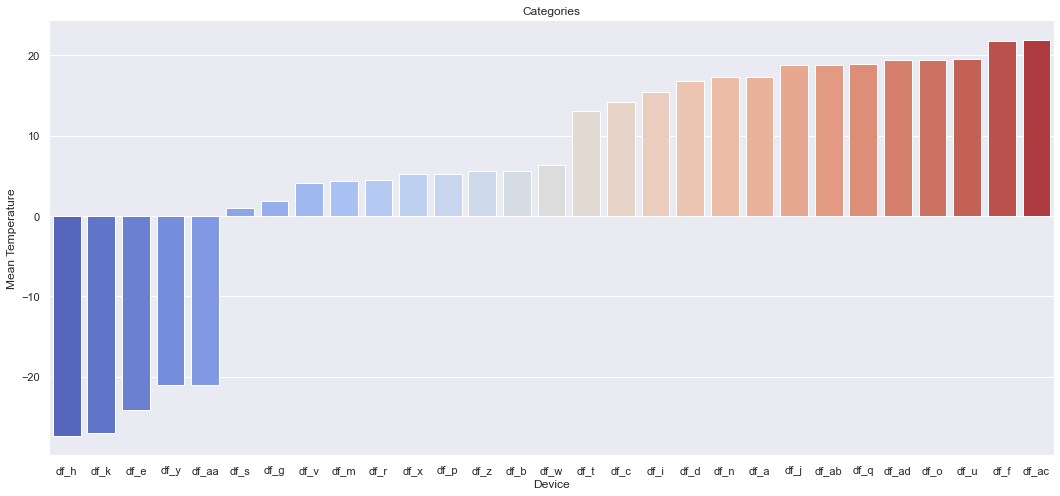

In [10]:
#sns.set_theme(style="whitegrid")
#sns.set_palette(sns.color_pallete("icefire"),as_cmap=True)
sns.set(rc={'figure.figsize':(18,8)})
sns.barplot(x="Device", 
            y="Mean Temperature", 
            data=mean_temp_dev,
            order=mean_temp_dev.sort_values('Mean Temperature').Device,
            palette = "coolwarm").set(title='Categories')
plt.show()

After plotting the dictionary we can easily see the average temperature for each dataframe and compare them to one another. This will help us with categorizing and labeling our dataframes.

## Categorizing Dataframes

After careful consideration and discussion we decided to seperate our dataframes into three distinct categories: Freezer, Fridge, Pantry

In [11]:
#barchart per category
#check the order
mean_temp_dev.sort_values(by='Mean Temperature',ascending=True).T

,11,14,8,27,1,21,10,24,15,20,...,16,0,13,2,19,4,17,23,9,3
Device,df_h,df_k,df_e,df_y,df_aa,df_s,df_g,df_v,df_m,df_r,...,df_n,df_a,df_j,df_ab,df_q,df_ad,df_o,df_u,df_f,df_ac
Mean Temperature,-27.33,-26.97,-24.13,-21.1,-21.0,0.96,1.91,4.14,4.37,4.53,...,17.24,17.33,18.83,18.83,18.89,19.41,19.43,19.53,21.75,21.87


In [12]:
#categories
categories = []
for value in mean_temp_dev['Mean Temperature']:
    if value < 0: categories.append('Freezer')
    elif 0 <= value < 10: categories.append('Fridge')
    elif 10 <= value :categories.append('Pantry')
    else: categories.append('unknown')
        
mean_temp_dev['Categories']  = categories
mean_temp_dev.T

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
Device,df_a,df_aa,df_ab,df_ac,df_ad,df_b,df_c,df_d,df_e,df_f,...,df_q,df_r,df_s,df_t,df_u,df_v,df_w,df_x,df_y,df_z
Mean Temperature,17.33,-21.0,18.83,21.87,19.41,5.55,14.15,16.84,-24.13,21.75,...,18.89,4.53,0.96,13.0,19.53,4.14,6.36,5.19,-21.1,5.54
Categories,Pantry,Freezer,Pantry,Pantry,Pantry,Fridge,Pantry,Pantry,Freezer,Pantry,...,Pantry,Fridge,Fridge,Pantry,Pantry,Fridge,Fridge,Fridge,Freezer,Fridge


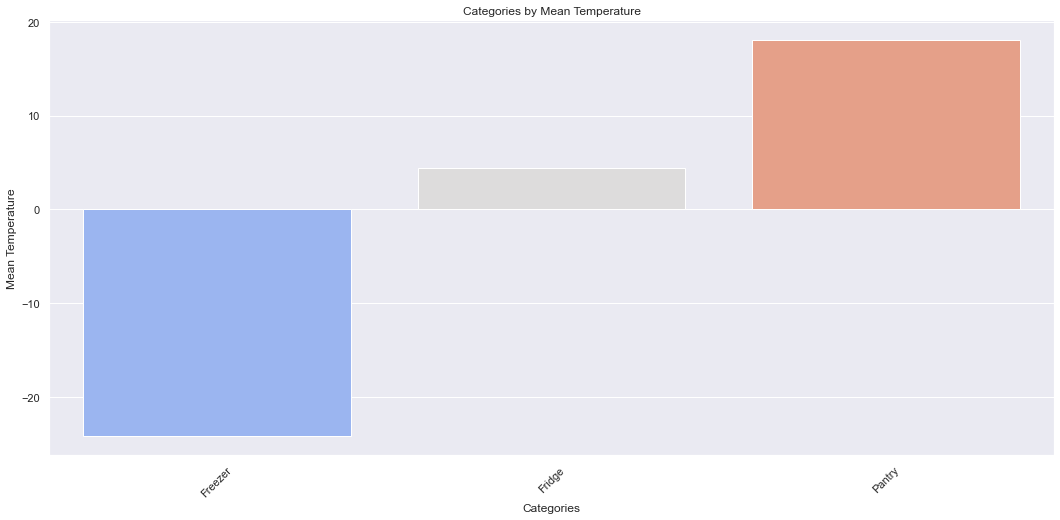

In [13]:
#barchart per group
sns.barplot(data=mean_temp_dev,
                x="Categories",
                y="Mean Temperature",
                palette = "coolwarm",
                ci=None,
                order=["Freezer", "Fridge","Pantry"])
plt.title('Categories by Mean Temperature')
plt.xticks(rotation=45)
plt.show()

# Visuallization By Category

Here we plot every dataframe divided based on category from which we will pick the most apropriate dataset to train our model on. In order for dataframe to be deemed apropriate for further analysis it needs to fufill the following conditions:
- Data Consistency
- None or very little missing values
- Upper and lower alarm threshold (Optional)

## Freezer Category

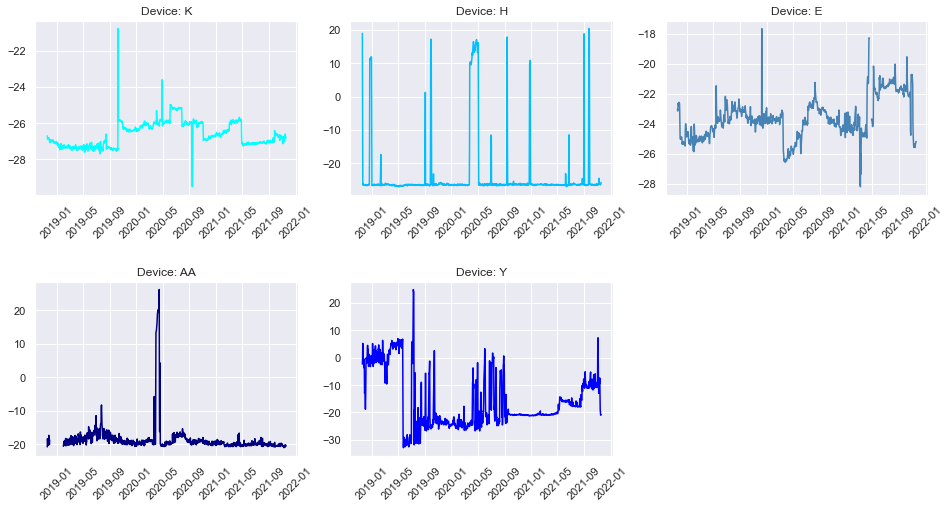

In [14]:
fig = plt.figure(figsize=(16, 8))
# Height Margin
plt.subplots_adjust(hspace=0.5)
#plot 1
fig.add_subplot(2,3,1)
plt.plot(df_k_daily["Temp"],color='aqua')
plt.title('Device: K')
plt.xticks(rotation=45)
#fig.autofmt_xdate()

#plot 2
plt.subplot(2,3,2)
plt.plot(df_h_daily["Temp"],color='deepskyblue')
plt.title('Device: H')
plt.xticks(rotation=45)

#plot 3
plt.subplot(2,3,3)
plt.plot(df_e_daily["Temp"],color='steelblue')
plt.title('Device: E')
plt.xticks(rotation=45)

#plot 4
plt.subplot(2,3,4)
plt.plot(df_aa_daily["Temp"],color='navy')
plt.title('Device: AA')
plt.xticks(rotation=45)

#plot 5
plt.subplot(2,3,5)
plt.plot(df_y_daily["Temp"],color='blue')
plt.title('Device: Y')
plt.xticks(rotation=45)
plt.show()

## Fridge Category

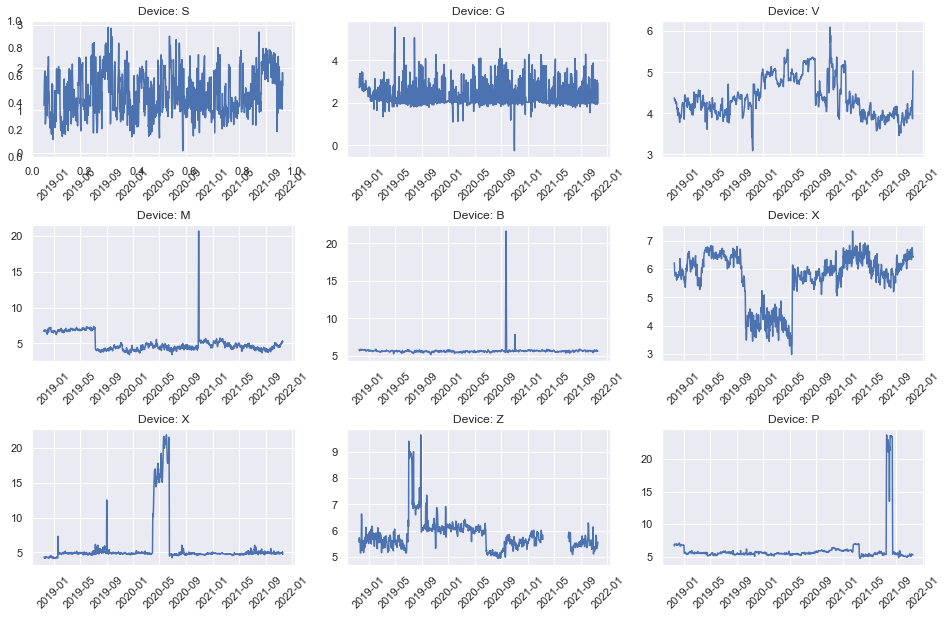

In [15]:
#pic size
fig, axes = plt.subplots(3,3, figsize=(16,10))
# Sub-plot Margin
plt.subplots_adjust(hspace=0.5)

#plot 1
fig.add_subplot(3,3,1)
plt.plot(df_s_daily["Temp"])
plt.title('Device: S')
plt.xticks(rotation=45)

#plot 2
plt.subplot(3,3,2)
plt.plot(df_g_daily["Temp"])
plt.title('Device: G')
plt.xticks(rotation=45)

#plot 3
plt.subplot(3,3,3)
plt.plot(df_v_daily["Temp"])
plt.title('Device: V')
plt.xticks(rotation=45)

#plot 4
plt.subplot(3,3,4)
plt.plot(df_m_daily["Temp"])
plt.title('Device: M')
plt.xticks(rotation=45)

#plot 5
plt.subplot(3,3,5)
plt.plot(df_b_daily["Temp"])
plt.title('Device: B')
plt.xticks(rotation=45)

#plot 6
plt.subplot(3,3,6)
plt.plot(df_x_daily["Temp"])
plt.title('Device: X')
plt.xticks(rotation=45)

#plot 7
plt.subplot(3,3,7)
plt.plot(df_r_daily["Temp"])
plt.title('Device: X')
plt.xticks(rotation=45)

#plot 8
plt.subplot(3,3,8)
plt.plot(df_z_daily["Temp"])
plt.title('Device: Z')
plt.xticks(rotation=45)

#plot 9
plt.subplot(3,3,9)
plt.plot(df_p_daily["Temp"])
plt.title('Device: P')
plt.xticks(rotation=45)
plt.show()

## Pantry Category

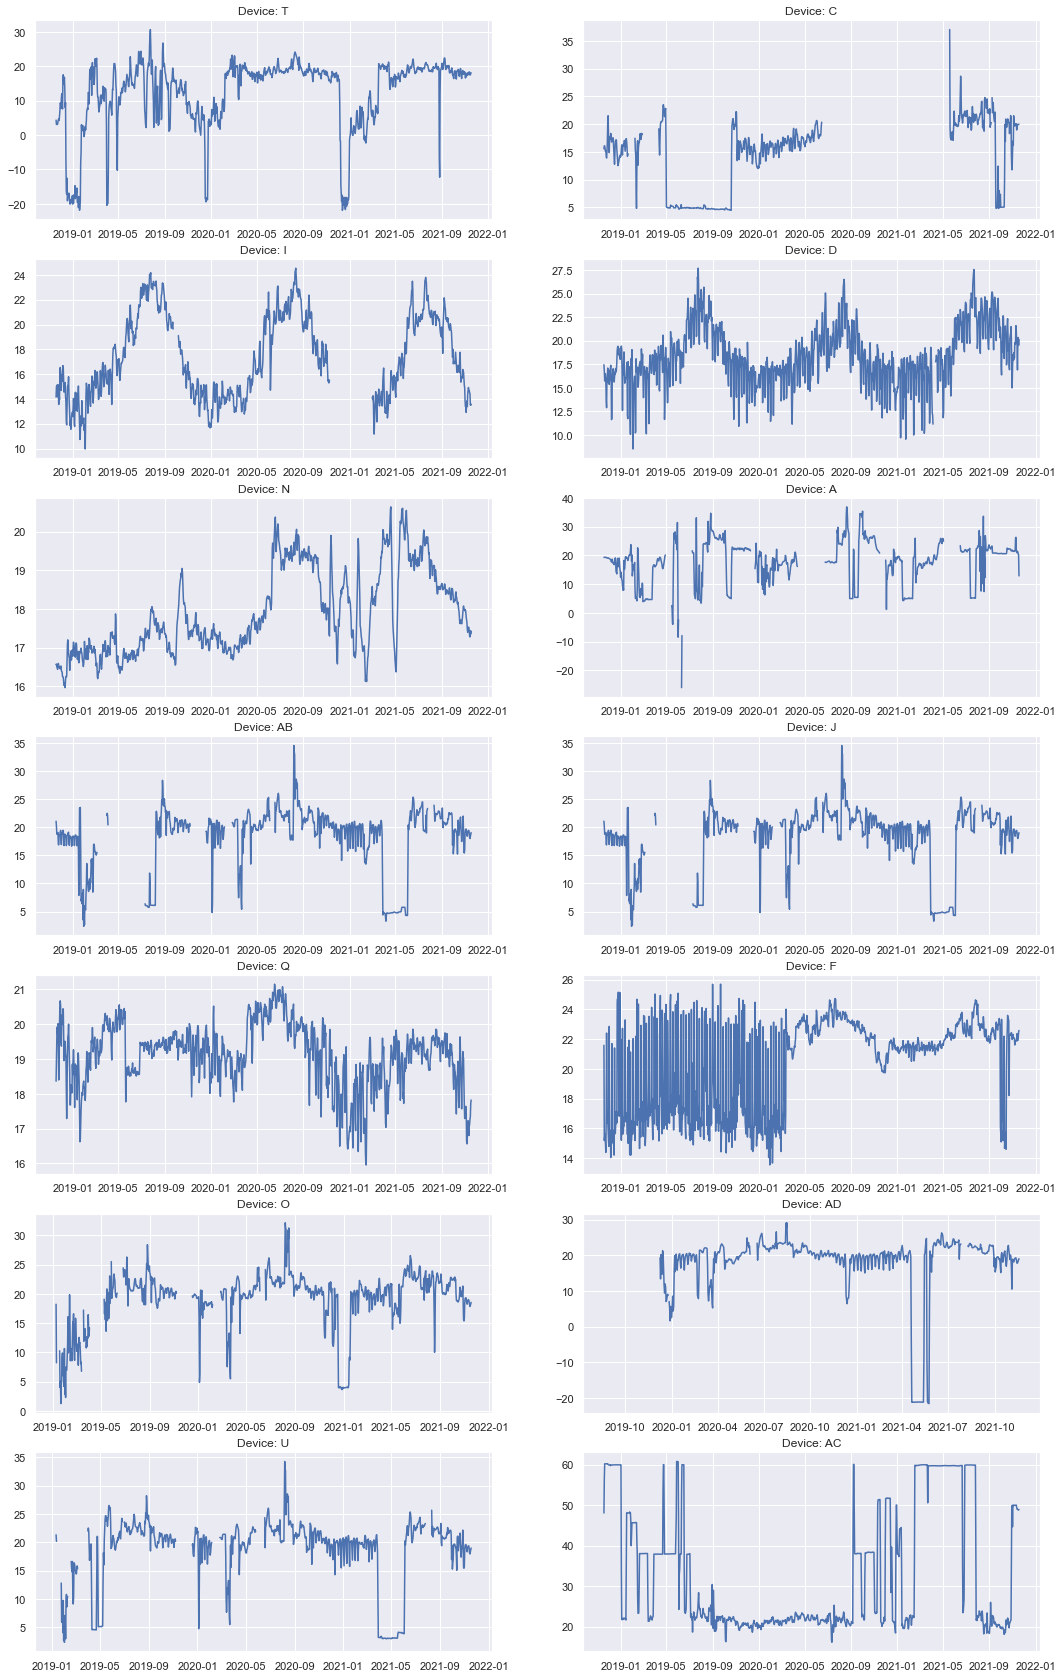

In [16]:
fig, axes = plt.subplots(7,2, figsize=(18,30))
axes[0,0].plot(df_t_daily["Temp"])
axes[0,1].plot(df_c_daily["Temp"])
axes[1,0].plot(df_i_daily["Temp"])
axes[1,1].plot(df_d_daily["Temp"])
axes[2,0].plot(df_n_daily["Temp"])
axes[2,1].plot(df_a_daily["Temp"])
axes[3,0].plot(df_ab_daily["Temp"])
axes[3,1].plot(df_j_daily["Temp"])
axes[4,0].plot(df_q_daily["Temp"])
axes[4,1].plot(df_f_daily["Temp"])
axes[5,0].plot(df_o_daily["Temp"])
axes[5,1].plot(df_ad_daily["Temp"])
axes[6,0].plot(df_u_daily["Temp"])
axes[6,1].plot(df_ac_daily["Temp"])
axes[0,0].set_title('Device: T')
axes[0,1].set_title('Device: C')
axes[1,0].set_title('Device: I')
axes[1,1].set_title('Device: D')
axes[2,0].set_title('Device: N')
axes[2,1].set_title('Device: A')
axes[3,0].set_title('Device: AB')
axes[3,1].set_title('Device: J')
axes[4,0].set_title('Device: Q')
axes[4,1].set_title('Device: F')
axes[5,0].set_title('Device: O')
axes[5,1].set_title('Device: AD')
axes[6,0].set_title('Device: U')
axes[6,1].set_title('Device: AC')
plt.show()

# Further Analysis

After manually picking three datasets from each category we are ready to explore them and pick one for each category

## Freezers

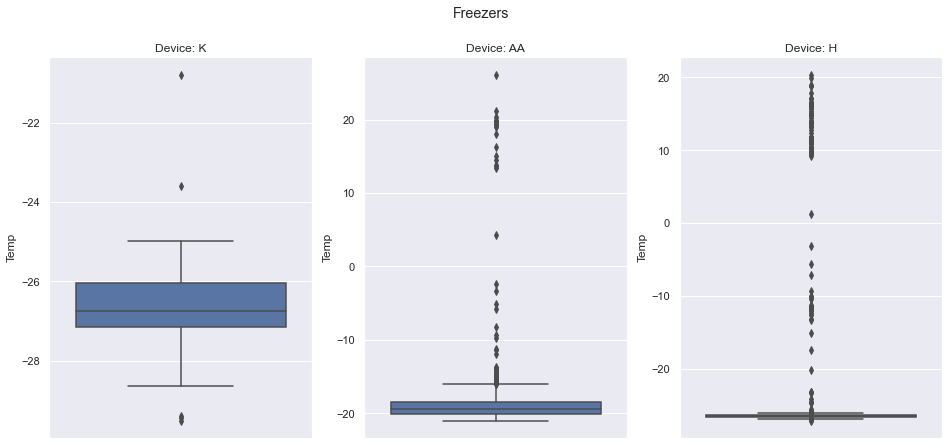

In [17]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Freezers')
sns.boxplot(ax=axes[0],y="Temp",data=df_k_daily)
sns.boxplot(ax=axes[1],y="Temp",data=df_aa_daily)
sns.boxplot(ax=axes[2],y="Temp",data=df_h_daily)
axes[0].set_title('Device: K')
axes[1].set_title('Device: AA')
axes[2].set_title('Device: H')
plt.show()

## Fridges

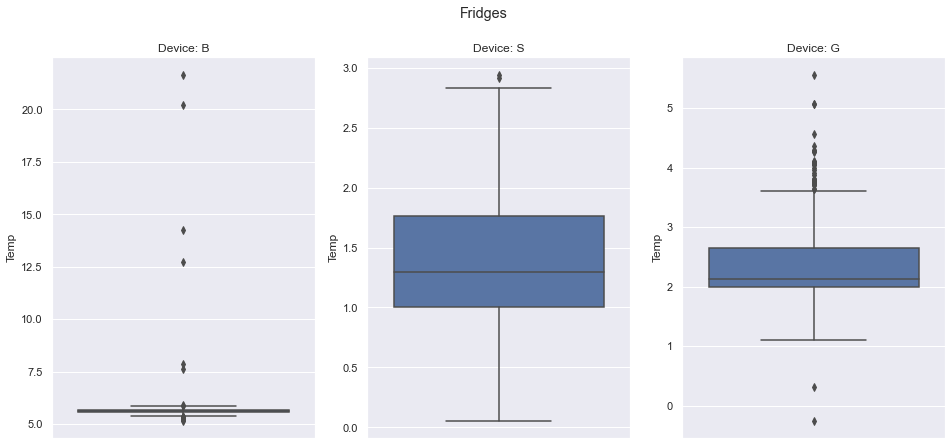

In [18]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Fridges')
sns.boxplot(ax=axes[0],y="Temp",data=df_b_daily)
sns.boxplot(ax=axes[1],y="Temp",data=df_s_daily)
sns.boxplot(ax=axes[2],y="Temp",data=df_g_daily)
axes[0].set_title('Device: B')
axes[1].set_title('Device: S')
axes[2].set_title('Device: G')
plt.show()

## Pantries

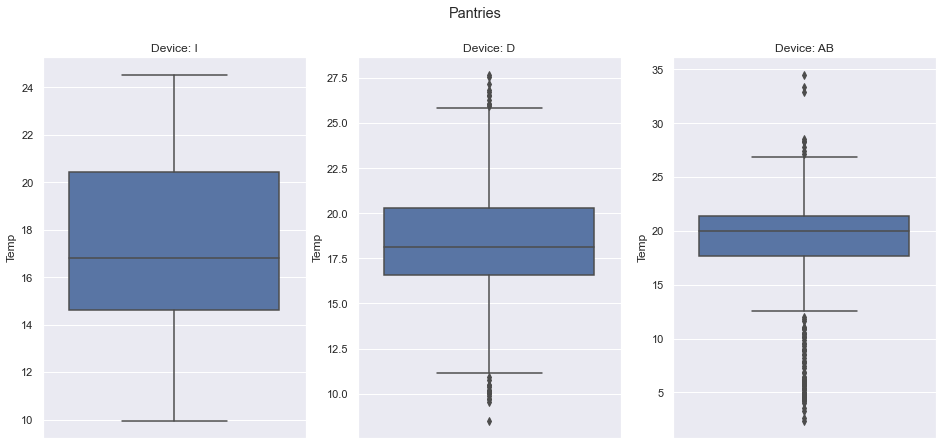

In [19]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Pantries')
sns.boxplot(ax=axes[0],y="Temp",data=df_i_daily)
sns.boxplot(ax=axes[1],y="Temp",data=df_d_daily)
sns.boxplot(ax=axes[2],y="Temp",data=df_ab_daily)
axes[0].set_title('Device: I')
axes[1].set_title('Device: D')
axes[2].set_title('Device: AB')
plt.show()

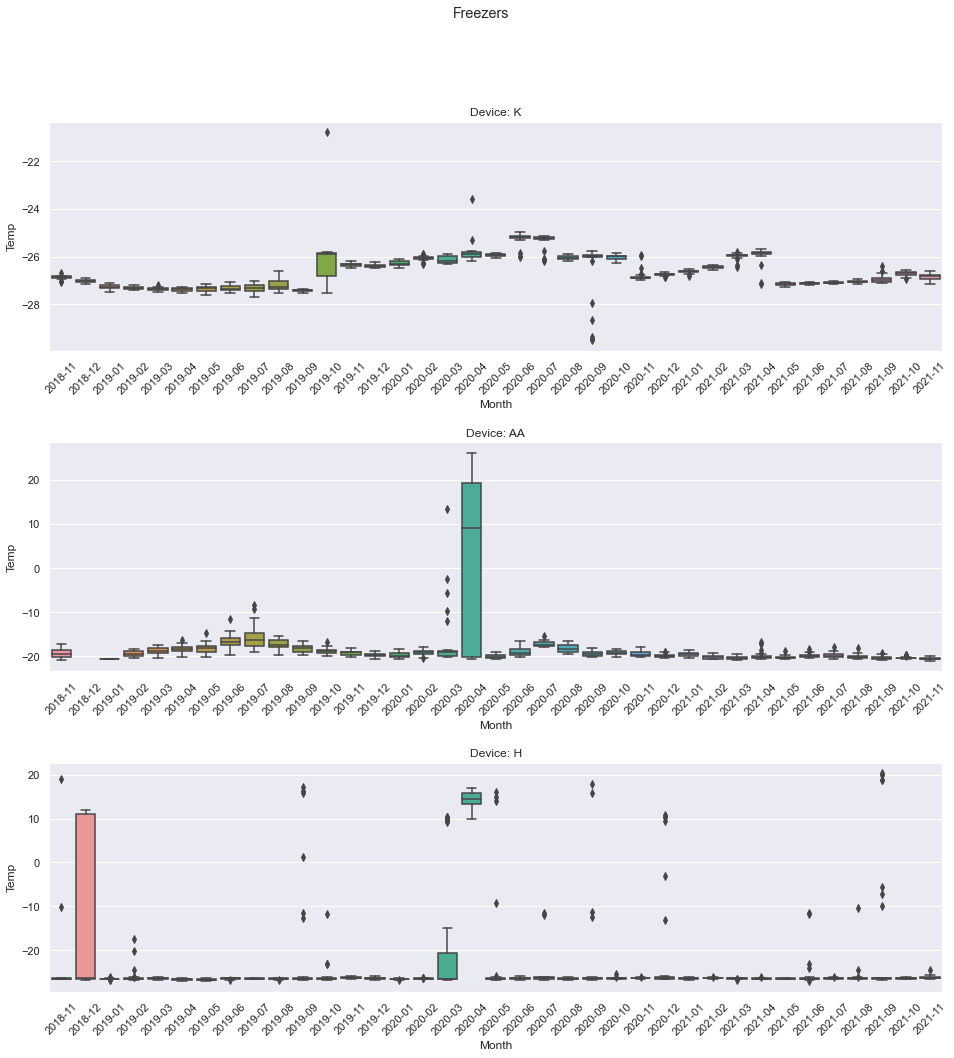

In [20]:
df_k_copy = df_k_daily.copy()
df_k_copy["Month"] = df_k_copy.index.to_period('M')

df_aa_copy = df_aa_daily.copy()
df_aa_copy["Month"] = df_aa_copy.index.to_period('M')

df_h_copy = df_h_daily.copy()
df_h_copy["Month"] = df_h_copy.index.to_period('M')

fig, axes = plt.subplots(3,1, figsize=(16,16))
plt.subplots_adjust(hspace=0.4)
fig.suptitle('Freezers')
sns.boxplot(ax=axes[0],x="Month",y="Temp",data=df_k_copy)
sns.boxplot(ax=axes[1],x="Month",y="Temp",data=df_aa_copy)
sns.boxplot(ax=axes[2],x="Month",y="Temp",data=df_h_copy)
axes[0].set_title('Device: K')
axes[1].set_title('Device: AA')
axes[2].set_title('Device: H')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 45)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 45)
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation = 45)
plt.show()

# Data Zoom in

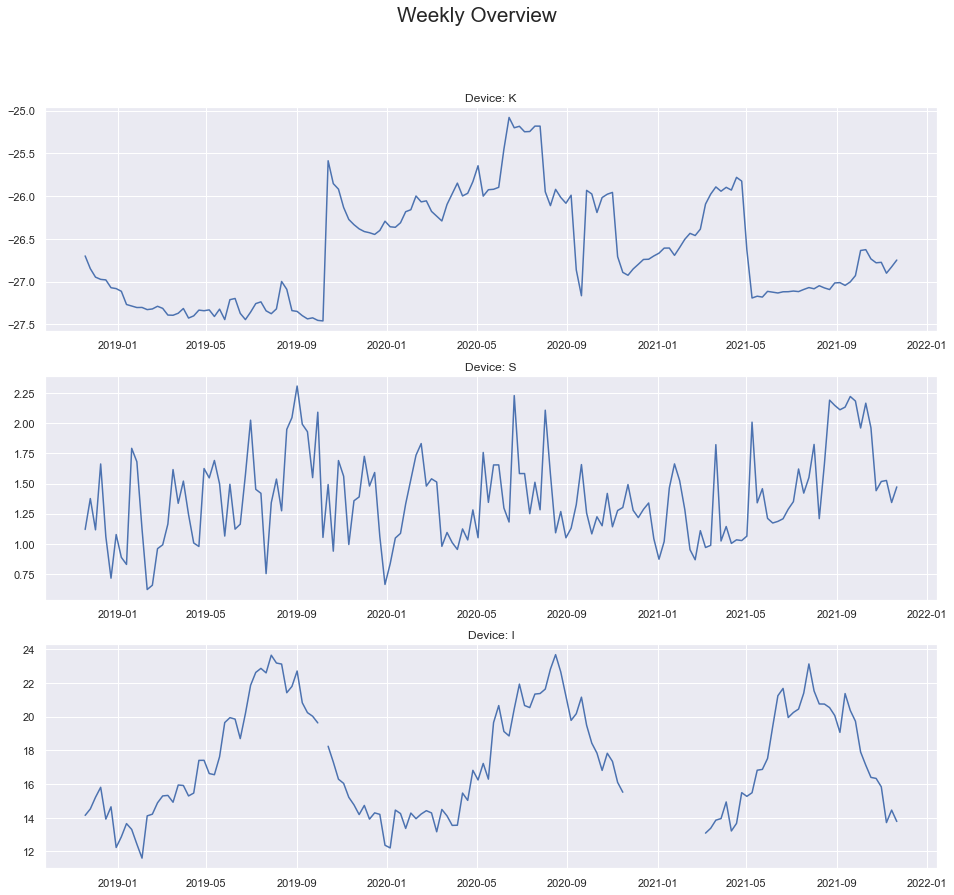

In [21]:
fig, axes = plt.subplots(3, figsize=(16,14))
fig.suptitle('Weekly Overview',fontsize="xx-large")
axes[0].plot(df_k_weekly)
axes[1].plot(df_s_weekly)
axes[2].plot(df_i_weekly)
axes[0].set_title('Device: K')
axes[1].set_title('Device: S')
axes[2].set_title('Device: I')
plt.show()

## Hourly Zoom

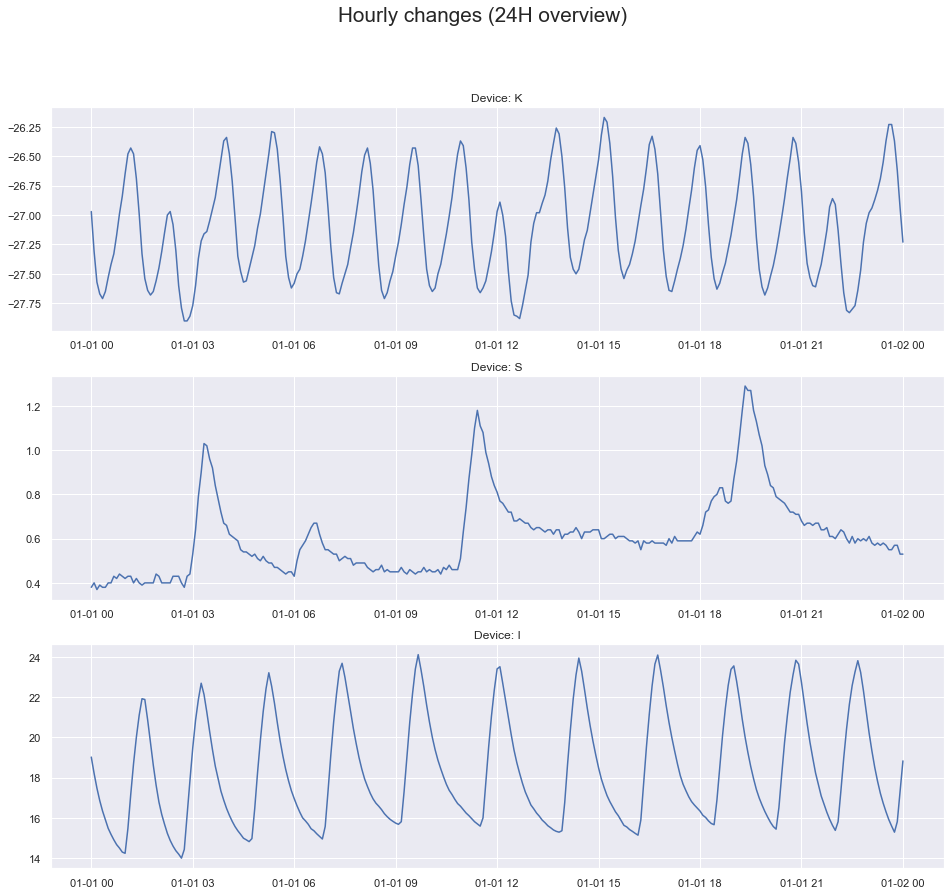

In [22]:
df_k_zoom = df_k.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]
df_s_zoom = df_s.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]
df_i_zoom = df_d.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]

fig, axes = plt.subplots(3, figsize=(16,14))
fig.suptitle('Hourly changes (24H overview)',fontsize="xx-large")
axes[0].plot(df_k_zoom)
axes[1].plot(df_s_zoom)
axes[2].plot(df_i_zoom)
axes[0].set_title('Device: K')
axes[1].set_title('Device: S')
axes[2].set_title('Device: I')
plt.show()

# Modelling

In [23]:
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed 
set_random_seed(0)

# from prophet import Prophet

## I can not get normal prophet to work without it getting stuck

In [24]:
m = NeuralProphet()
help(m)

Help on NeuralProphet in module neuralprophet.forecaster object:

class NeuralProphet(builtins.object)
 |  NeuralProphet(growth='linear', changepoints=None, n_changepoints=10, changepoints_range=0.9, trend_reg=0, trend_reg_threshold=False, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', seasonality_mode='additive', seasonality_reg=0, n_forecasts=1, n_lags=0, num_hidden_layers=0, d_hidden=None, ar_sparsity=None, learning_rate=None, epochs=None, batch_size=None, loss_func='Huber', optimizer='AdamW', newer_samples_weight=2, newer_samples_start=0.0, impute_missing=True, collect_metrics=True, normalize='auto', global_normalization=False, global_time_normalization=True, unknown_data_normalization=False)
 |  
 |  NeuralProphet forecaster.
 |  
 |  A simple yet powerful forecaster that models:
 |  Trend, seasonality, events, holidays, auto-regression, lagged covariates, and future-known regressors.
 |  Can be regualrized and configured to model nonlinear relatio

In [25]:
df_i.T

EventDt,2018-11-18 16:35:00,2018-11-18 16:40:00,2018-11-18 16:45:00,2018-11-18 16:50:00,2018-11-18 16:55:00,2018-11-18 17:00:00,2018-11-18 17:05:00,2018-11-18 17:10:00,2018-11-18 17:15:00,2018-11-18 17:20:00,...,2021-11-18 15:45:00,2021-11-18 15:50:00,2021-11-18 15:55:00,2021-11-18 16:00:00,2021-11-18 16:05:00,2021-11-18 16:10:00,2021-11-18 16:15:00,2021-11-18 16:20:00,2021-11-18 16:25:00,2021-11-18 16:30:00
Temp,14.6,14.63,14.6,14.57,14.59,14.57,14.54,14.52,14.54,14.52,...,14.66,14.67,14.65,14.64,14.65,14.65,14.66,14.64,14.65,14.64


In [26]:
df_i["ds"] = df_i.index
df_i = df_i.rename(columns={"Temp": "y"})
df_i.T

EventDt,2018-11-18 16:35:00,2018-11-18 16:40:00,2018-11-18 16:45:00,2018-11-18 16:50:00,2018-11-18 16:55:00,2018-11-18 17:00:00,2018-11-18 17:05:00,2018-11-18 17:10:00,2018-11-18 17:15:00,2018-11-18 17:20:00,...,2021-11-18 15:45:00,2021-11-18 15:50:00,2021-11-18 15:55:00,2021-11-18 16:00:00,2021-11-18 16:05:00,2021-11-18 16:10:00,2021-11-18 16:15:00,2021-11-18 16:20:00,2021-11-18 16:25:00,2021-11-18 16:30:00
y,14.6,14.63,14.6,14.57,14.59,14.57,14.54,14.52,14.54,14.52,...,14.66,14.67,14.65,14.64,14.65,14.65,14.66,14.64,14.65,14.64
ds,2018-11-18 16:35:00,2018-11-18 16:40:00,2018-11-18 16:45:00,2018-11-18 16:50:00,2018-11-18 16:55:00,2018-11-18 17:00:00,2018-11-18 17:05:00,2018-11-18 17:10:00,2018-11-18 17:15:00,2018-11-18 17:20:00,...,2021-11-18 15:45:00,2021-11-18 15:50:00,2021-11-18 15:55:00,2021-11-18 16:00:00,2021-11-18 16:05:00,2021-11-18 16:10:00,2021-11-18 16:15:00,2021-11-18 16:20:00,2021-11-18 16:25:00,2021-11-18 16:30:00


In [27]:
df_i.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315648 entries, 2018-11-18 16:35:00 to 2021-11-18 16:30:00
Freq: 5T
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   y       278713 non-null  float64       
 1   ds      315648 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.2 MB


In [28]:
import warnings
warnings.filterwarnings('ignore')

m = NeuralProphet(yearly_seasonality=True,
#                   weekly_seasonality=False, 
#                   daily_seasonality=False,
                 )

metrics = m.fit(df_i, freq="D")
metrics

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 100.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T
INFO - (NP.forecaster.__handle_missing_data) - dropped 36935 NAN row in 'y'
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 21


  0%|          | 0/372 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.37E-01, min: 1.08E+00


  0%|          | 0/372 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.30E-01, min: 1.21E+00


  0%|          | 0/372 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.30E-01, min: 1.28E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.32E-01
Epoch[21/21]: 100%|█████████████| 21/21 [01:17<00:00,  3.68s/it, SmoothL1Loss=0.00126, MAE=0.886, RMSE=1.14, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.075919,4.738112,5.881322,0.0
1,0.001551,0.982588,1.270937,0.0
2,0.002350,1.226054,1.562446,0.0
3,0.003539,1.515833,1.916093,0.0
4,0.004969,1.799040,2.264148,0.0
5,0.005718,1.929390,2.422188,0.0
6,0.005955,1.961703,2.462879,0.0
7,0.005942,1.960565,2.463627,0.0
8,0.005240,1.846032,2.321313,0.0
9,0.004902,1.774043,2.231621,0.0


In [29]:
future = m.make_future_dataframe(df_i, periods=365, n_historic_predictions=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 100.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T


INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.884% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.884% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T


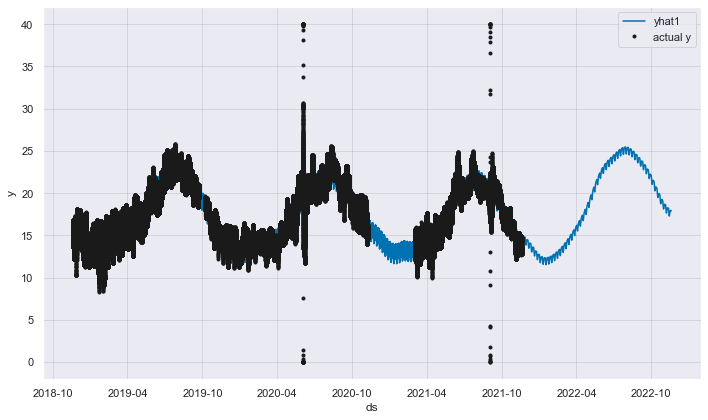

In [30]:
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [31]:
forecast

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,season_daily
0,2018-11-18 16:35:00,14.6,15.333361,0.733361,17.569218,-2.444126,-0.538939,0.747209
1,2018-11-18 16:40:00,14.63,15.334394,0.704394,17.569294,-2.444292,-0.538564,0.747956
2,2018-11-18 16:45:00,14.6,15.335214,0.735214,17.569372,-2.444457,-0.538180,0.748478
3,2018-11-18 16:50:00,14.57,15.335771,0.765771,17.569448,-2.444623,-0.537786,0.748729
4,2018-11-18 16:55:00,14.59,15.336020,0.74602,17.569527,-2.444788,-0.537384,0.748665
...,...,...,...,...,...,...,...,...
316008,2022-11-14 16:30:00,None,17.567558,NaN,19.272892,-2.249129,-0.202488,0.746281
316009,2022-11-15 16:30:00,None,17.874126,NaN,19.280539,-2.298979,0.146285,0.746281
316010,2022-11-16 16:30:00,None,17.944469,NaN,19.288185,-2.347918,0.257923,0.746281
316011,2022-11-17 16:30:00,None,17.912645,NaN,19.295830,-2.396171,0.266706,0.746281


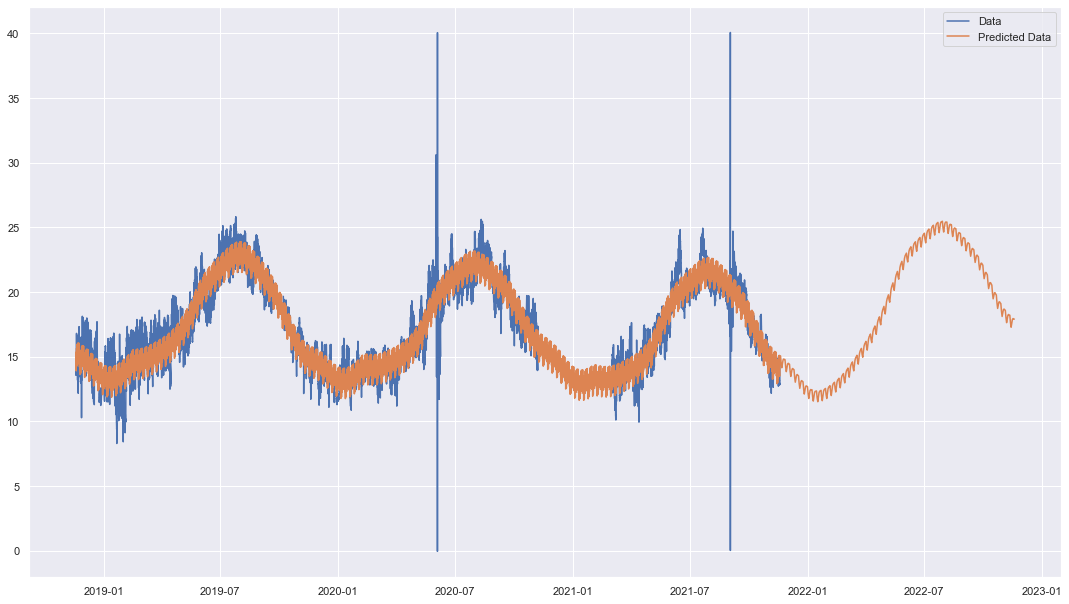

In [32]:
fig, ax = plt.subplots()
ax.plot(forecast["ds"],forecast["y"], label="Data")
ax.plot(forecast["ds"],forecast["yhat1"],label="Predicted Data")
ax.legend(loc = 'upper right')
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

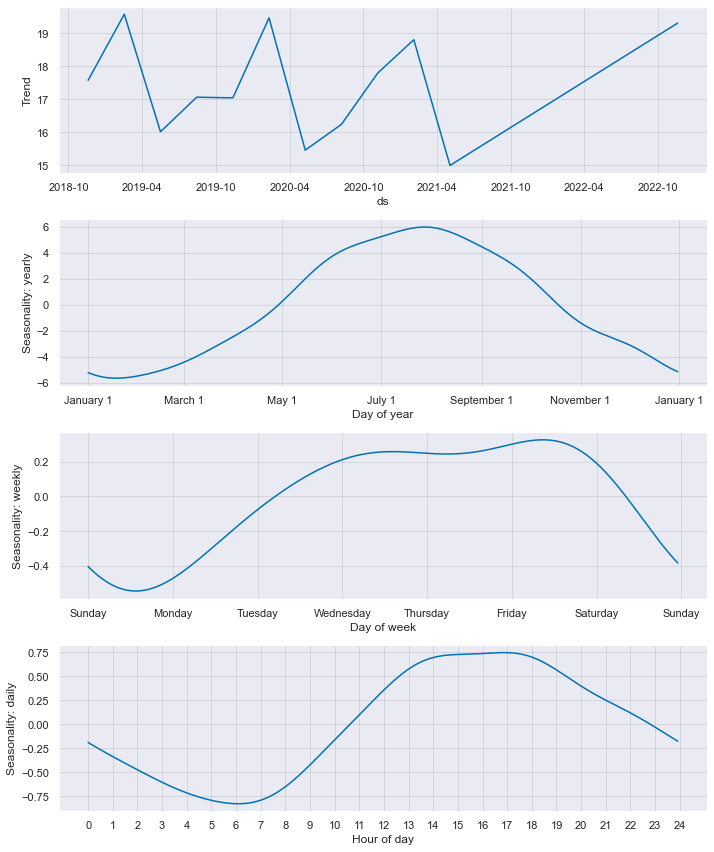

In [33]:
fig2 = m.plot_components(forecast)

In [34]:
## https://neuralprophet.com/html/test_and_crossvalidate.html
## Need to add crossvalidation